In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import os,gc
import sys
import shutil
import math
import random
import heapq 
import time
import copy
import itertools  
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,auc,roc_auc_score 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
torch.cuda.set_device(6)
print (torch.cuda.current_device())

6


In [2]:
#preparing the trainset and  testset
img_path = '/data/fjsdata/NIH-CXR/images/images/' 
trN, trI, trY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/train.txt', "r") as file_descriptor: #tarinset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            trN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            trY.append(np.array(image_label))
            img = cv2.resize(cv2.imread(os.path.join(img_path, image_name)).astype(np.float32), (256, 256))#(256,256,3)
            trI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(trN),78468))
        sys.stdout.flush()
trI = np.array(trI)
trY = np.array(trY)   
print('The length of trainset is %d'%len(trN))
        
valN, valI, valY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/val.txt', "r") as file_descriptor: #valset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            valN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            valY.append(np.array(image_label))
            img = cv2.resize(cv2.imread(os.path.join(img_path, image_name)).astype(np.float32), (256, 256))#(256,256,3)
            valI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(valN),11219))
        sys.stdout.flush()
valI = np.array(valI)
valY = np.array(valY) 
print('The length of validset is %d'%len(valN))

teN, teI, teY = [],[],[]
with open('/data/fjsdata/NIH-CXR/chexnet_dataset/test.txt', "r") as file_descriptor: #testset
    lines = file_descriptor.readlines()
    for line in lines:
        try:
            line_items = line.split()
            image_name = line_items[0].split('/')[1]
            teN.append(image_name)
            image_label = line_items[1:]  # 14 labels from index 2
            image_label = [int(i) for i in image_label]  
            teY.append(np.array(image_label))
            img = cv2.resize(cv2.imread(os.path.join(img_path, image_name)).astype(np.float32), (256, 256))#(256,256,3)
            teI.append(img)
        except:
            print(image_name+":"+str(os.path.join(img_path, image_name)))
        sys.stdout.write('\r{} / {} '.format(len(teN),22433))
        sys.stdout.flush()
teI = np.array(teI)
teY = np.array(teY)    
print('The length of testset is %d'%len(teN))

78468 / 78468 The length of trainset is 78468
11219 / 11219 The length of validset is 11219
22433 / 22433 The length of testset is 22433


In [13]:
# construct model
class DenseNet121(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet121, self).__init__()
        self.dense_net_121 = torchvision.models.densenet121(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_121.classifier.in_features
        self.dense_net_121.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_121(x)
        return x


class DenseNet169(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet169, self).__init__()
        self.dense_net_169 = torchvision.models.densenet169(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_169.classifier.in_features
        self.dense_net_169.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_169(x)
        return x


class DenseNet201(nn.Module):
    def __init__(self, num_classes, is_pre_trained):
        super(DenseNet201, self).__init__()
        self.dense_net_201 = torchvision.models.densenet201(pretrained=is_pre_trained)
        num_fc_kernels = self.dense_net_201.classifier.in_features
        self.dense_net_201.classifier = nn.Sequential(nn.Linear(num_fc_kernels, num_classes), nn.Sigmoid())

    def forward(self, x):
        x = self.dense_net_201(x)
        return x

In [17]:
#model training
N_CLASSES = 14 #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
#torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 10 #'Batch Size': 32
for epoch in range(10):#'Max Epoch': 1000
    num_batches = len(trY) // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(trY), (i+1)*batchSize])
            I_batch = torch.from_numpy(trI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#forword
            curr_loss = criterion(y_outputs, y_batch)
            sys.stdout.write('\r {} / {} : loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    print("Eopch: %5d val_loss = %.6f" % (epoch + 1, np.mean(loss_val)))
    if np.mean(loss_val) < best_loss:
        best_loss = np.mean(loss_val)
        best_net = copy.deepcopy(model)        
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
I_batch = I_batch.cpu()
y_batch = y_batch.cpu()
torch.cuda.empty_cache()

 1122 / 1122 : loss = 0.229734Eopch:     1 val_loss = 0.179797
 1122 / 1122 : loss = 0.224769Eopch:     2 val_loss = 0.178051
 1122 / 1122 : loss = 0.219881Eopch:     3 val_loss = 0.174272
 1122 / 1122 : loss = 0.222542Eopch:     4 val_loss = 0.172049
 1122 / 1122 : loss = 0.225083Eopch:     5 val_loss = 0.170893
 1122 / 1122 : loss = 0.219798Eopch:     6 val_loss = 0.170776
 1122 / 1122 : loss = 0.222643Eopch:     7 val_loss = 0.169828
 1122 / 1122 : loss = 0.223932Eopch:     8 val_loss = 0.169610
 1122 / 1122 : loss = 0.223391Eopch:     9 val_loss = 0.169516
 1122 / 1122 : loss = 0.226725Eopch:    10 val_loss = 0.168812
best_loss = 0.168812


In [18]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch.permute(0, 3, 1, 2))#forword
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 2243 / 2244 The average AUROC is 0.6997
The AUROC of Atelectasis is 0.7278
The AUROC of Cardiomegaly is 0.6968
The AUROC of Effusion is 0.8015
The AUROC of Infiltration is 0.6485
The AUROC of Mass is 0.6341
The AUROC of Nodule is 0.5937
The AUROC of Pneumonia is 0.6514
The AUROC of Pneumothorax is 0.6878
The AUROC of Consolidation is 0.7600
The AUROC of Edema is 0.8164
The AUROC of Emphysema is 0.6528
The AUROC of Fibrosis is 0.7062
The AUROC of Pleural_Thickening is 0.6628
The AUROC of Hernia is 0.7562


In [19]:
#model training
N_CLASSES = 14 #class numbers
model = DenseNet169(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
#torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 10 #'Batch Size': 32
for epoch in range(10):#'Max Epoch': 1000
    num_batches = len(trY) // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(trY), (i+1)*batchSize])
            I_batch = torch.from_numpy(trI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#forword
            curr_loss = criterion(y_outputs, y_batch)
            sys.stdout.write('\r {} / {} : loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    print("Eopch: %5d val_loss = %.6f" % (epoch + 1, np.mean(loss_val)))
    if np.mean(loss_val) < best_loss:
        best_loss = np.mean(loss_val)
        best_net = copy.deepcopy(model)        
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
I_batch = I_batch.cpu()
y_batch = y_batch.cpu()
torch.cuda.empty_cache()

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 57365526/57365526 [07:50<00:00, 121986.03it/s]


 1122 / 1122 : loss = 0.306353Eopch:     1 val_loss = 0.266647
 1122 / 1122 : loss = 0.225867Eopch:     2 val_loss = 0.180029
 1122 / 1122 : loss = 0.217373Eopch:     3 val_loss = 0.176112
 1122 / 1122 : loss = 0.220139Eopch:     4 val_loss = 0.176237
 1122 / 1122 : loss = 0.230699Eopch:     5 val_loss = 0.178417
 1122 / 1122 : loss = 0.218961Eopch:     6 val_loss = 0.176261
 1122 / 1122 : loss = 0.222816Eopch:     7 val_loss = 0.173360
 1122 / 1122 : loss = 0.224277Eopch:     8 val_loss = 0.171827
 1122 / 1122 : loss = 0.225518Eopch:     9 val_loss = 0.170091
 1122 / 1122 : loss = 0.226122Eopch:    10 val_loss = 0.168863
best_loss = 0.168863


In [20]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch.permute(0, 3, 1, 2))#forword
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 2243 / 2244 The average AUROC is 0.6858
The AUROC of Atelectasis is 0.7172
The AUROC of Cardiomegaly is 0.6627
The AUROC of Effusion is 0.7969
The AUROC of Infiltration is 0.6481
The AUROC of Mass is 0.6212
The AUROC of Nodule is 0.5825
The AUROC of Pneumonia is 0.6580
The AUROC of Pneumothorax is 0.6671
The AUROC of Consolidation is 0.7678
The AUROC of Edema is 0.8258
The AUROC of Emphysema is 0.6450
The AUROC of Fibrosis is 0.7055
The AUROC of Pleural_Thickening is 0.6343
The AUROC of Hernia is 0.6687


In [30]:
#Exclude the normal samples.
index = np.where(np.sum(trY, axis=1) != 0 )[0] 
trY_ex = trY[index]
trI_ex = trI[index]
print(trI_ex.shape)
index = np.where(np.sum(valY, axis=1) != 0 )[0]
valY_ex = valY[index]
valI_ex = valI[index]
print(valI_ex.shape)
index = np.where(np.sum(teY, axis=1) != 0 )[0] 
teY_ex = teY[index]
teI_ex = teI[index]
print(teI_ex.shape)

(36063, 256, 256, 3)
(5140, 14)
(10505, 256, 256, 3)


In [35]:
#model training
N_CLASSES = 14 #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
#torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = torch.nn.BCELoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 10 #'Batch Size': 32
for epoch in range(10):#'Max Epoch': 1000
    num_batches = len(trY_ex) // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(trY_ex), (i+1)*batchSize])
            I_batch = torch.from_numpy(trI_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : train loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY_ex) // batchSize #+1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY_ex), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY_ex[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#forword
            curr_loss = criterion(y_outputs, y_batch)
            sys.stdout.write('\r {} / {} : validation loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY_ex)  # tensor
    scheduler.step(mean_loss_tensor.item())
    print("Eopch: %5d val_loss = %.6f" % (epoch + 1, np.mean(loss_val)))
    if np.mean(loss_val) < best_loss:
        best_loss = np.mean(loss_val)
        best_net = copy.deepcopy(model)        
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
I_batch = I_batch.cpu()
y_batch = y_batch.cpu()
torch.cuda.empty_cache()

 514 / 514 : validation loss = 0.255188Eopch:     1 val_loss = 0.320859
 514 / 514 : validation loss = 0.250327Eopch:     2 val_loss = 0.300148
 514 / 514 : validation loss = 0.238933Eopch:     3 val_loss = 0.299890
 514 / 514 : validation loss = 0.227912Eopch:     4 val_loss = 0.294252
 514 / 514 : validation loss = 0.235433Eopch:     5 val_loss = 0.293694
 514 / 514 : validation loss = 0.230859Eopch:     6 val_loss = 0.290944
 514 / 514 : validation loss = 0.233728Eopch:     7 val_loss = 0.291892
 514 / 514 : validation loss = 0.258102Eopch:     8 val_loss = 0.296948
 514 / 514 : validation loss = 0.266383Eopch:     9 val_loss = 0.298607
 514 / 514 : validation loss = 0.251328Eopch:    10 val_loss = 0.296055
best_loss = 0.290944


In [37]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch.permute(0, 3, 1, 2))#forword
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

 2243 / 2244 The average AUROC is 0.6489
The AUROC of Atelectasis is 0.6657
The AUROC of Cardiomegaly is 0.6783
The AUROC of Effusion is 0.7411
The AUROC of Infiltration is 0.5947
The AUROC of Mass is 0.5074
The AUROC of Nodule is 0.5416
The AUROC of Pneumonia is 0.6522
The AUROC of Pneumothorax is 0.6274
The AUROC of Consolidation is 0.7321
The AUROC of Edema is 0.7948
The AUROC of Emphysema is 0.5760
The AUROC of Fibrosis is 0.6518
The AUROC of Pleural_Thickening is 0.5812
The AUROC of Hernia is 0.7399


In [38]:
class CircleLoss(nn.Module):
    def __init__(self, scale=32, margin=0.25, similarity='cos', **kwargs):
        super(CircleLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.similarity = similarity

    def forward(self, feats, labels):
        assert feats.size(0) == labels.size(0), \
            f"feats.size(0): {feats.size(0)} is not equal to labels.size(0): {labels.size(0)}"
        batch_size = feats.size(0)
        if self.similarity == 'dot':
            sim_mat = torch.matmul(feats, torch.t(feats))
        elif self.similarity == 'cos':
            feats = F.normalize(feats)
            sim_mat = feats.mm(feats.t())
        else:
            raise ValueError('This similarity is not implemented.')
        loss = list()
        for i in range(batch_size):
            pos_index = labels == labels[i]
            pos_index[i] = 0
            neg_index = labels != labels[i]
            pos_pair_ = sim_mat[i][pos_index]
            neg_pair_ = sim_mat[i][neg_index]

            alpha_p = torch.relu(-pos_pair_ + 1 + self.margin)
            alpha_n = torch.relu(neg_pair_ + self.margin)
            margin_p = 1 - self.margin
            margin_n = self.margin
            loss_p = torch.sum(torch.exp(-self.scale * alpha_p * (pos_pair_ - margin_p)))
            loss_n = torch.sum(torch.exp(self.scale * alpha_n * (neg_pair_ - margin_n)))
            loss.append(torch.log(1 + loss_p * loss_n))

        loss = sum(loss) / batch_size
        return loss

In [39]:
#model training
N_CLASSES = 14 #class numbers
model = DenseNet121(num_classes=N_CLASSES, is_pre_trained=True).cuda()#initialize model
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2, 3, 4, 5, 6, 7]).cuda()# make model available multi GPU cores training
#torch.backends.cudnn.benchmark = True  # improve train speed slightly
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, mode='min')
criterion = CircleLoss()
#train model
best_net, best_loss = None, float('inf')
batchSize = 10 #'Batch Size': 32
for epoch in range(10):#'Max Epoch': 1000
    num_batches = len(trY) // batchSize + 1
    model.train()  # set network as train mode
    with torch.autograd.enable_grad():
        for i in range(num_batches):
            optimizer.zero_grad()#grad vanish
            min_idx = i * batchSize
            max_idx = np.min([len(trY), (i+1)*batchSize])
            I_batch = torch.from_numpy(trI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(trY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            #forword
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#permute the dims of matrix
            #loss
            loss = criterion(y_outputs, y_batch)
            loss.backward()
            #update parameters
            optimizer.step()
            sys.stdout.write('\r {} / {} : loss = {}'.format(i+1, num_batches, float('%0.6f'%loss.item())))
            sys.stdout.flush()     
    #validation process
    loss_val = []
    mean_loss_tensor = 0.
    num_batches = len(valY) // batchSize  +1
    model.eval()  # set network as eval mode without BN & Dropout
    with torch.autograd.no_grad():
        for j in range(num_batches):
            min_idx = j * batchSize
            max_idx = np.min([len(valY), (j+1)*batchSize])
            I_batch = torch.from_numpy(valI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_batch = torch.from_numpy(valY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
            y_outputs = model(I_batch.permute(0, 3, 1, 2))#forword
            curr_loss = criterion(y_outputs, y_batch)
            sys.stdout.write('\r {} / {} : loss = {}'.format(j + 1, num_batches, float('%0.6f'%curr_loss.item()) ) )
            sys.stdout.flush()  
            mean_loss_tensor += curr_loss  # tensor op.
            loss_val.append(curr_loss.item())
    mean_loss_tensor = mean_loss_tensor / len(valY)  # tensor
    scheduler.step(mean_loss_tensor.item())
    print("Eopch: %5d val_loss = %.6f" % (epoch + 1, np.mean(loss_val)))
    if np.mean(loss_val) < best_loss:
        best_loss = np.mean(loss_val)
        best_net = copy.deepcopy(model)        
print("best_loss = %.6f" % (best_loss))
model = model.cpu()#release gpu memory
I_batch = I_batch.cpu()
y_batch = y_batch.cpu()
torch.cuda.empty_cache()

IndexError: too many indices for tensor of dimension 1

In [ ]:
#performance of testset
# initialize the ground truth and output tensor
gt = torch.FloatTensor().cuda()
pred = torch.FloatTensor().cuda()
num_batches = len(teY) // batchSize  +1
best_net.eval()  # set network as eval mode without BN & Dropout
with torch.autograd.no_grad():
    for i in range(num_batches):
        min_idx = i * batchSize
        max_idx = np.min([len(teY), (i+1)*batchSize])
        I_batch = torch.from_numpy(teI[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        y_batch = torch.from_numpy(teY[min_idx:max_idx]).type(torch.FloatTensor).cuda()
        gt = torch.cat((gt, y_batch), 0)
        y_outputs = best_net(I_batch.permute(0, 3, 1, 2))#forword
        pred = torch.cat((pred, y_outputs.data), 0)
        sys.stdout.write('\r {} / {} '.format(i, num_batches))
        sys.stdout.flush()
    
CLASS_NAMES = ['Atelectasis', 'Cardiomegaly', 'Effusion','Infiltration', 'Mass', 'Nodule', 'Pneumonia', \
               'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'] 
def compute_AUCs(gt, pred):
    AUROCs = []
    gt_np = gt.cpu().numpy()
    pred_np = pred.cpu().numpy()
    for i in range(N_CLASSES):
        AUROCs.append(roc_auc_score(gt_np[:, i], pred_np[:, i]))
    return AUROCs

AUROCs = compute_AUCs(gt, pred)
AUROC_avg = np.array(AUROCs).mean()
print('The average AUROC is {AUROC_avg:.4f}'.format(AUROC_avg=AUROC_avg))
for i in range(N_CLASSES):
    print('The AUROC of {} is {:.4f}'.format(CLASS_NAMES[i], AUROCs[i]))

In [12]:
#Assert that there is no patient overlap between the splits
for i in range(len(trN)):
    for j in range(len(teN)):
        if(trN[i].split('_')[0] == teN[j].split('_')[0]):
            print(trN[i])
for i in range(len(valN)):
    for j in range(len(teN)):
        if(valN[i].split('_')[0] == teN[j].split('_')[0]):
            print(valN[i])

Prediction Interval: 20.204
95% likelihood that the true value is between 162.920 and 203.328
True value: 180.955


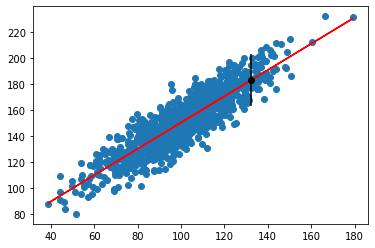

In [21]:
# linear regression prediction with prediction interval
from numpy.random import randn
from numpy.random import seed
from numpy import power
from numpy import sqrt
from numpy import mean
from numpy import std
from numpy import sum as arraysum
from scipy.stats import linregress
from matplotlib import pyplot
# seed random number generator
seed(1)
# prepare data
x = 20 * randn(1000) + 100
y = x + (10 * randn(1000) + 50)
# fit linear regression model
b1, b0, r_value, p_value, std_err = linregress(x, y)
# make predictions
yhat = b0 + b1 * x
# define new input, expected value and prediction
x_in = x[0]
y_out = y[0]
yhat_out = yhat[0]
# estimate stdev of yhat
sum_errs = arraysum((y - yhat)**2)
stdev = sqrt(1/(len(y)-2) * sum_errs)
# calculate prediction interval
interval = 1.96 * stdev #95%
print('Prediction Interval: %.3f' % interval)
lower, upper = yhat_out - interval, yhat_out + interval
print('95%% likelihood that the true value is between %.3f and %.3f' % (lower, upper))
print('True value: %.3f' % y_out)
# plot dataset and prediction with interval
pyplot.scatter(x, y)
pyplot.plot(x, yhat, color='red')
pyplot.errorbar(x_in, yhat_out, yerr=interval, color='black', fmt='o')
pyplot.show()